<a href="https://colab.research.google.com/github/Ni-cole17/Diabetes-IA/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Direcionamento ao diretório e importação de bibliotecas







In [1]:
%cd /content/drive/My Drive/Bases

/content/drive/My Drive/Bases


In [5]:
from scipy.io import arff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Importação da base de dados em arff

In [6]:
data = arff.loadarff('diabetes.arff')
df_diabetes = pd.DataFrame(data[0])

### Visualização inicial da base de dados e dos seus atributos

In [7]:
df_diabetes.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


A base de dados acima irá ser utilizada para prever se uma pessoa é mais provável de ter diabetes dados alguns fatores como: 
- Número de gestações (preg)
- Nível de glicose no plasma sanguíneo (plas)
- Pressão arterial diastólica (pres)
- Espessura da dobra cutânea (skin)
- Nível de insulina em U/ml (insu)
- Índice de massa corporal (mass)
- Probabilidade de diabetes com base na história familiar (pedi)
- Idade da pessoa (age).

### Verificando se tem algum dado nulo na base de dados

In [8]:
df_diabetes.info()  # A classe dessa base de dados é do tipo object, vou precisar transformar para o tipo inteiro para a classificação

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    float64
 1   plas    768 non-null    float64
 2   pres    768 non-null    float64
 3   skin    768 non-null    float64
 4   insu    768 non-null    float64
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    float64
 8   class   768 non-null    object 
dtypes: float64(8), object(1)
memory usage: 54.1+ KB


In [9]:
df_diabetes.isnull().sum() # A base de dados não possui nenhum dado nulo, logo não precisará de um tratamento nos dados

preg     0
plas     0
pres     0
skin     0
insu     0
mass     0
pedi     0
age      0
class    0
dtype: int64

Após fazer a separação dos dados, antes de ir para a etapa de classificação, vamos entender como cada um dos atributos afetam a diabetes.

### Distribuição das variáveis

In [18]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=4, cols=2,subplot_titles=("Distribuição Etária","Distribuição por IMC","Distribuição por # de Gestações","Distribuição por prob. de diabetes","Nível de insulina em U/ml","Nível de glicose no plasma sanguíneo","Espessura da dobra cutânea","Pressão arterial diastólica"))
fig.add_trace(go.Histogram(x=df_diabetes['age']), row=1, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['mass']), row=1, col=2)
fig.add_trace(go.Histogram(x=df_diabetes['preg']), row=2, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['pedi']), row=2, col=2)
fig.add_trace(go.Histogram(x=df_diabetes['insu']), row=3, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['plas']), row=3, col=2)
fig.add_trace(go.Histogram(x=df_diabetes['skin']), row=4, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['pres']), row=4, col=2)
fig.show()

Essa distribuição melhora a visualização de outliers. Logo, os próximos passos é identificar outliers em cada uma das features.

Uma delas que indica muito possivelmente a presença de outliers é a feature Pressão arterial diastólica, visto que vemos no gráfico que existem valores entre 0-4. No entanto, olhando do ponto de vista biológico, é impossível que uma pessoa que esteja viva tenha uma pressão diastólica nesses valores. Em geral a pressão diastólica do ser humano varia de valores entre 60-90.

In [20]:
df_diabetes['pres'].describe()

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: pres, dtype: float64

In [39]:
pres_outlier = df_diabetes.query('pres < 30')
pres_outlier

,preg,plas,pres,skin,insu,mass,pedi,age,class
7,10.0,115.0,0.0,0.0,0.0,35.3,0.134,29.0,b'tested_negative'
15,7.0,100.0,0.0,0.0,0.0,30.0,0.484,32.0,b'tested_positive'
49,7.0,105.0,0.0,0.0,0.0,0.0,0.305,24.0,b'tested_negative'
60,2.0,84.0,0.0,0.0,0.0,0.0,0.304,21.0,b'tested_negative'
78,0.0,131.0,0.0,0.0,0.0,43.2,0.270,26.0,b'tested_positive'
81,2.0,74.0,0.0,0.0,0.0,0.0,0.102,22.0,b'tested_negative'
172,2.0,87.0,0.0,23.0,0.0,28.9,0.773,25.0,b'tested_negative'
193,11.0,135.0,0.0,0.0,0.0,52.3,0.578,40.0,b'tested_positive'
222,7.0,119.0,0.0,0.0,0.0,25.2,0.209,37.0,b'tested_negative'
261,3.0,141.0,0.0,0.0,0.0,30.0,0.761,27.0,b'tested_positive'


Outra feature que tem possívelmente outliers é a distribuição por IMC, que aparenta ter valores negativos ou muito baixos.


In [35]:
df_diabetes['mass'].describe()

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: mass, dtype: float64

In [38]:
mass_outlier = df_diabetes.query('mass < 10')
mass_outlier

,preg,plas,pres,skin,insu,mass,pedi,age,class
9,8.0,125.0,96.0,0.0,0.0,0.0,0.232,54.0,b'tested_positive'
49,7.0,105.0,0.0,0.0,0.0,0.0,0.305,24.0,b'tested_negative'
60,2.0,84.0,0.0,0.0,0.0,0.0,0.304,21.0,b'tested_negative'
81,2.0,74.0,0.0,0.0,0.0,0.0,0.102,22.0,b'tested_negative'
145,0.0,102.0,75.0,23.0,0.0,0.0,0.572,21.0,b'tested_negative'
371,0.0,118.0,64.0,23.0,89.0,0.0,1.731,21.0,b'tested_negative'
426,0.0,94.0,0.0,0.0,0.0,0.0,0.256,25.0,b'tested_negative'
494,3.0,80.0,0.0,0.0,0.0,0.0,0.174,22.0,b'tested_negative'
522,6.0,114.0,0.0,0.0,0.0,0.0,0.189,26.0,b'tested_negative'
684,5.0,136.0,82.0,0.0,0.0,0.0,0.640,69.0,b'tested_negative'


Observando essas duas análises, vemos que existem muitos dados que tem uma linha com 3 zeros ou mais, isso quer dizer, com dados faltantes, isso não é benéfico para nossa posterior classificação, logo esses dados com mais de 3 zeros irei deletar do data frame.

In [169]:
indexes = []
for i in range(len(df_diabetes)):
  linha = list(df_diabetes.iloc[i])
  zeros = linha.count(0)
  if zeros > 3:
    indexes.append(i)
df_diabetes_new = df_diabetes.drop(df_diabetes.index[indexes])
df_diabetes_new

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,b'tested_positive'


In [170]:
df_diabetes_new['insu'].value_counts()

0.0      358
105.0     11
130.0      9
140.0      9
120.0      8
        ... 
73.0       1
171.0      1
255.0      1
52.0       1
112.0      1
Name: insu, Length: 186, dtype: int64

In [171]:
df_diabetes_new = df_diabetes_new.drop(columns=['insu'])
df_diabetes_new

,preg,plas,pres,skin,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,30.1,0.349,47.0,b'tested_positive'


In [172]:
df_diabetes_new.mass.mean()

32.26010638297872

In [173]:
df_diabetes_new.loc[df_diabetes_new.mass == 0,'mass'] = df_diabetes_new.mass.mean()

In [174]:
df_diabetes_new.loc[df_diabetes_new.plas == 0,'plas'] = df_diabetes_new.plas.mean()

In [175]:
df_diabetes_new.loc[df_diabetes_new.pres == 0,'pres'] = df_diabetes_new.pres.mean()

In [176]:
df_diabetes_new

,preg,plas,pres,skin,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,30.1,0.349,47.0,b'tested_positive'


In [177]:
fig = make_subplots(rows=4, cols=2,subplot_titles=("Distribuição Etária","Distribuição por IMC","Distribuição por # de Gestações","Distribuição por prob. de diabetes","Nível de glicose no plasma sanguíneo","Espessura da dobra cutânea","Pressão arterial diastólica"))
fig.add_trace(go.Histogram(x=df_diabetes_new['age']), row=1, col=1)
fig.add_trace(go.Histogram(x=df_diabetes_new['mass']), row=1, col=2)
fig.add_trace(go.Histogram(x=df_diabetes_new['preg']), row=2, col=1)
fig.add_trace(go.Histogram(x=df_diabetes_new['pedi']), row=2, col=2)
fig.add_trace(go.Histogram(x=df_diabetes_new['plas']), row=3, col=1)
fig.add_trace(go.Histogram(x=df_diabetes_new['skin']), row=3, col=2)
fig.add_trace(go.Histogram(x=df_diabetes_new['pres']), row=4, col=1)
fig.show()

In [ ]:
nomes_linhas = dict()
for i in range(df_diabetes_new.shape[0]):
  nomes_linhas[df_diabetes_new.index[i]] = i

In [ ]:
df_diabetes_new = df_diabetes_new.rename(index=nomes_linhas)

In [184]:
df_diabetes_new.tail()

,preg,plas,pres,skin,mass,pedi,age,class
747,10.0,101.0,76.0,48.0,32.9,0.171,63.0,b'tested_negative'
748,2.0,122.0,70.0,27.0,36.8,0.340,27.0,b'tested_negative'
749,5.0,121.0,72.0,23.0,26.2,0.245,30.0,b'tested_negative'
750,1.0,126.0,60.0,0.0,30.1,0.349,47.0,b'tested_positive'
751,1.0,93.0,70.0,31.0,30.4,0.315,23.0,b'tested_negative'


### Separação da base de dados em seus atributos (X) e classe (Y)

In [180]:
X = df_diabetes_new.loc[:,['preg', 'plas', 'pres', 'skin', 'mass', 'pedi', 'age']]
X

,preg,plas,pres,skin,mass,pedi,age
0,6.0,148.0,72.0,35.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,43.1,2.288,33.0
...,...,...,...,...,...,...,...
747,10.0,101.0,76.0,48.0,32.9,0.171,63.0
748,2.0,122.0,70.0,27.0,36.8,0.340,27.0
749,5.0,121.0,72.0,23.0,26.2,0.245,30.0
750,1.0,126.0,60.0,0.0,30.1,0.349,47.0


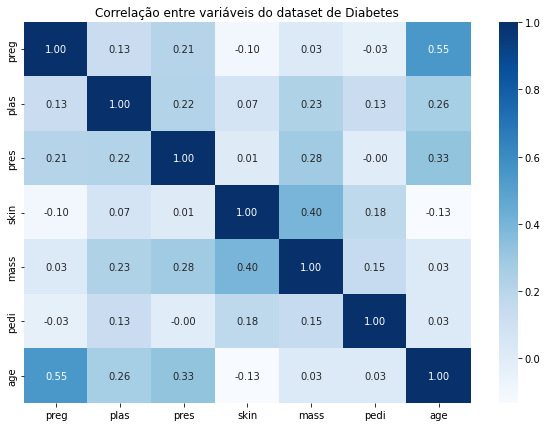

In [187]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_diabetes_new.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset de Diabetes')
plt.show()

Ainda nesse tratamento do data frame temos uma coluna que é o Nível de insulina em U/ml, no entanto, vemos que grande parte dos seus valores são nulos, logo não vejo como uma coluna que será interessante no dataframe, logo irei retirá-la.

As variáveis que tiveram mais correlação acima foram:

Número de Gestações e Idade: De fato essas duas variáveis podem estar relacionadas visto que é mais comum que mulheres mais velhas tenham mais filhos que mulheres mais jovens.

IMC e Dobra Cutânea também são variáveis bem correlacionadas visto que quanto maior o IMC mais provável ter uma dobra cutânea maior também.

In [181]:
Y = df_diabetes_new.loc[:,['class']]
Y

,class
0,b'tested_positive'
1,b'tested_negative'
2,b'tested_positive'
3,b'tested_negative'
4,b'tested_positive'
...,...
747,b'tested_negative'
748,b'tested_negative'
749,b'tested_negative'
750,b'tested_positive'


In [182]:
Y['class'] = Y['class'].replace(b'tested_negative',0)
Y['class'] = Y['class'].replace(b'tested_positive',1)
Y

,class
0,1
1,0
2,1
3,0
4,1
...,...
747,0
748,0
749,0
750,1


### Separação do dataset em Treino e Teste

In [188]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=100)

In [189]:
print(X_train.shape,Y_train.shape)
print(x_test.shape,y_test.shape)

(503, 7) (503, 1)
(249, 7) (249, 1)
